In [ ]:
%pip install chromadb
%pip install open-clip-torch

In [29]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [30]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f"{ROOT}/train")))
HNSW_SPACE = "hnsw:space"

In [31]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + '/' + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename 
            files_path.append(filepath)
    return files_path               

In [32]:
data_path = f"{ROOT}/train"
files_path = get_files_path(data_path)
files_path  

['data/train/African_crocodile/n01697457_10393.JPEG',
 'data/train/African_crocodile/n01697457_104.JPEG',
 'data/train/African_crocodile/n01697457_1331.JPEG',
 'data/train/African_crocodile/n01697457_14906.JPEG',
 'data/train/African_crocodile/n01697457_18587.JPEG',
 'data/train/African_crocodile/n01697457_260.JPEG',
 'data/train/African_crocodile/n01697457_5586.JPEG',
 'data/train/African_crocodile/n01697457_8136.JPEG',
 'data/train/African_crocodile/n01697457_8331.JPEG',
 'data/train/African_crocodile/n01697457_85.JPEG',
 'data/train/American_egret/n02009912_1358.JPEG',
 'data/train/American_egret/n02009912_13895.JPEG',
 'data/train/American_egret/n02009912_15872.JPEG',
 'data/train/American_egret/n02009912_16896.JPEG',
 'data/train/American_egret/n02009912_26245.JPEG',
 'data/train/American_egret/n02009912_36395.JPEG',
 'data/train/American_egret/n02009912_4403.JPEG',
 'data/train/American_egret/n02009912_5700.JPEG',
 'data/train/American_egret/n02009912_7609.JPEG',
 'data/train/Ame

In [33]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  
    plt.show()

### **Image Embedding**

In [34]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

In [22]:
img = Image.open('data/train/African_crocodile/n01697457_260.JPEG')
get_single_image_embedding(image=img)

[0.020757250487804413,
 0.01700527034699917,
 -0.05467657372355461,
 0.019303306937217712,
 0.000382948259357363,
 0.012467808090150356,
 -0.016283277422189713,
 -0.002152838511392474,
 0.050817977637052536,
 0.013185917399823666,
 -0.01208955142647028,
 0.007774764206260443,
 0.018893377855420113,
 -0.039419084787368774,
 0.011428140103816986,
 0.022981533780694008,
 -0.06464025378227234,
 0.026437917724251747,
 0.014886370860040188,
 0.0027106490451842546,
 -0.04403829947113991,
 -0.006418877746909857,
 0.005665409844368696,
 -0.030828293412923813,
 -0.016429908573627472,
 -0.0003537116863299161,
 0.005325565114617348,
 -0.015266208909451962,
 -0.007757543120533228,
 -0.025533445179462433,
 -0.012705329805612564,
 0.01918020285665989,
 0.0023711901158094406,
 0.014735797420144081,
 -0.026996122673153877,
 -0.03940673545002937,
 0.015418032184243202,
 -0.014308071695268154,
 -0.03243148699402809,
 0.010327613912522793,
 -0.01655525527894497,
 0.04119745269417763,
 -0.03550365194678306

### **Chromadb L2 Embedding Collection**

In [23]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [ ]:
chroma_client = chromadb.Client()

l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [02:16,  4.37it/s]


### **Search Image With L2 Collection**

In [35]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results 
    )
    return results

In [36]:
test_path = f'{ROOT}/test/'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(test_path, collection=l2_collection, n_results=5)

In [37]:
l2_results

{'ids': [['id_14', 'id_19', 'id_18', 'id_11', 'id_16']],
 'distances': [[0.4049486219882965,
   0.41227006912231445,
   0.5080227255821228,
   0.5198447704315186,
   0.5294203758239746]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

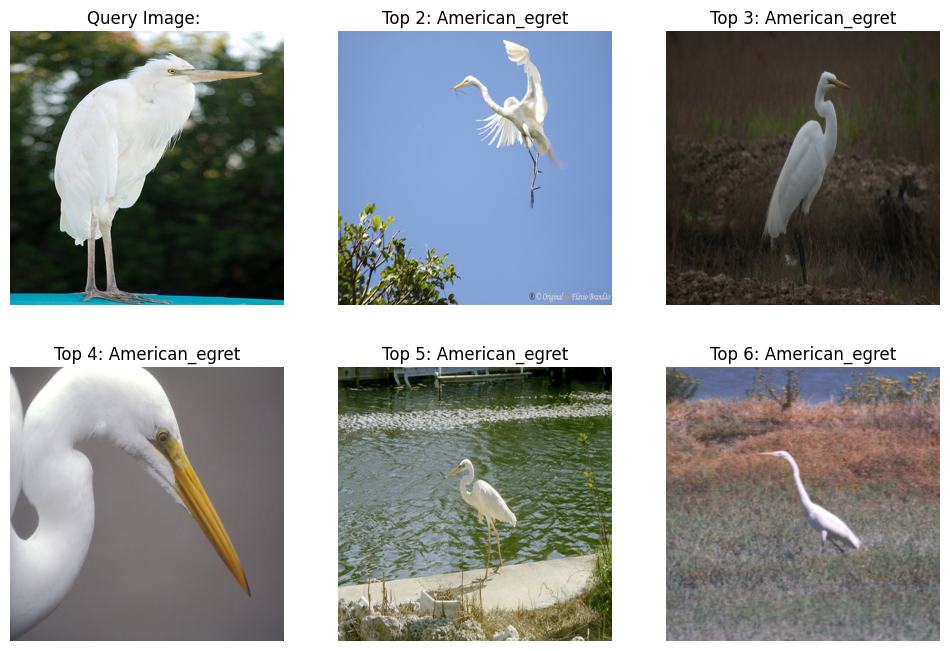

In [24]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

### **Search Image With Cosine Similarity Collection**

In [25]:

cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                           metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

595it [02:02,  4.87it/s]


In [38]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [39]:
cosine_results

{'ids': [['id_14', 'id_19', 'id_18', 'id_11', 'id_16']],
 'distances': [[0.20247411727905273,
   0.20613497495651245,
   0.25401145219802856,
   0.2599217891693115,
   0.264710009098053]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

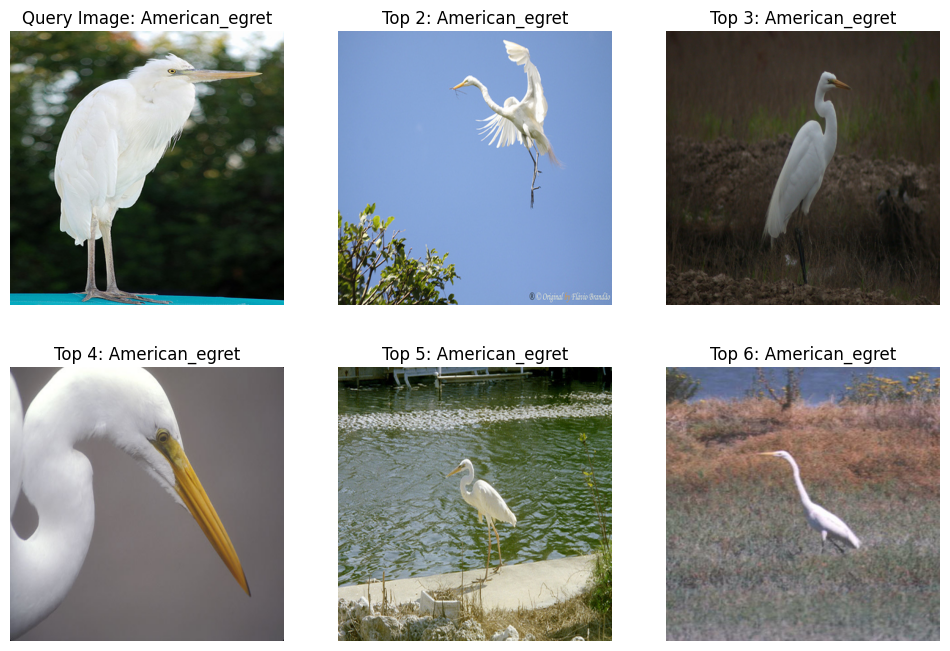

In [40]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)